## MAASTRO - MGH GBM Study
* Zhenwei Shi
* Susu Yan

In [1]:
import pandas as pd
from time import time
from keras import applications, optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,PReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from keras import preprocessing, layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, Callback, ReduceLROnPlateau
from numpy.random import seed
from tensorflow import set_random_seed
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import roc_auc_score,classification_report
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, Callback, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import sys
import yaml
import matplotlib.pyplot as plt
import os
import numpy
import pickle

import warnings; warnings.simplefilter('ignore')

Using TensorFlow backend.


### Load Data

In [2]:
# load pickle
pickle_in = open('x.pickle','rb')
x = pickle.load(pickle_in)
pickle_in = open('y.pickle','rb')
y = pickle.load(pickle_in)
# data normalization
x = x/255.0
y = np.array(y)

# for fast test
# x = x[0:500,]
# y = y[0:500,]

### Split data into training, validation and test

In [3]:
# create training and testing vars
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3,random_state = 1, shuffle = True)
x_trainn1, x_trainn2, y_trainn1, y_trainn2 = train_test_split(x_train, y_train, test_size = 0.5, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 1)
x_val1, x_val2, y_val1, y_val2 = train_test_split(x_val,y_val, test_size = 0.5, random_state =1)

print('DL Image size: ', np.shape(x_trainn1)[1:3])
print('CL Training samples: %d' % x_train.shape[0])
print('CL Validation samples: %d' % x_val.shape[0])

# print('DL Training Data: node1(n = %d), node2(n = %d)'
#       % (np.shape(x_trainn1)[0],np.shape(x_trainn2)[0]))
# print('DL Validation Data: node1(n = %d), node2(n = %d)'
#       % (np.shape(x_val1)[0],np.shape(x_val2)[0]))
# print('DL Test Data: n = %d'
#       % np.shape(x_test)[0])

DL Image size:  (50, 50)
CL Training samples: 17462
CL Validation samples: 3742


### How many samples for each class are there in the dataset?

0    1874
1    1868
dtype: int64


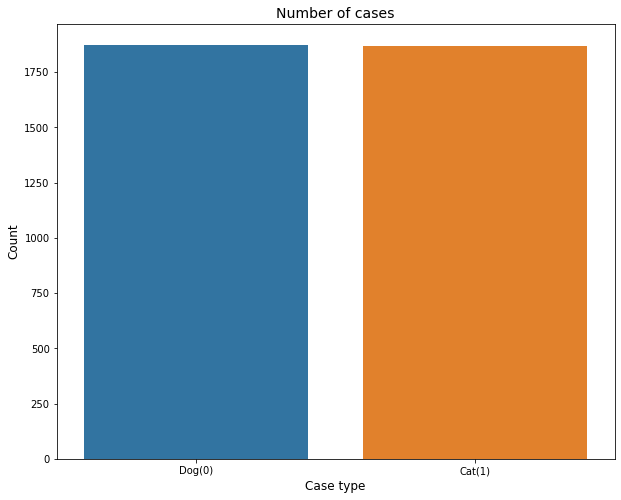

In [103]:
# Get the counts for each class
# dog with label 0, cat with label 1
import pandas as pd
import seaborn as sns
df_ytest = pd.Series(y_test) # must be pandas Series
cases_count = df_ytest.value_counts()

print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Dog(0)', 'Cat(1)'])
plt.show()

In [4]:
tf.random.set_random_seed(1234)
# initial parameters
num_iter = 20
epoch = 1
total_epoch = num_iter*epoch
batch_size = 32

bestweights = rootdir + logtitle + "_weights.best.hdf5"
logtitle = "MGH_GBM_ZW"
tensorboard = TensorBoard(log_dir= './models/'+  logtitle, write_graph=False)

In [5]:
# Add a dropout layer to fight overfitting as well
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=x.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))                       # DROPOUT
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
             optimizer='SGD',
             metrics=['acc'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)        

In [7]:
 # Use data augmentation
train_datagen = preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size)

# do not augment validation data
test_datagen = preprocessing.image.ImageDataGenerator()
validation_generator = test_datagen.flow(
    x_val,
    y_val,
    batch_size=len(x_val))

In [8]:
#FAST_RUN = True # controls whether to run kernel fast
FAST_RUN = False

# checkpoints=ModelCheckpoint(bestweights, monitor='val_loss',verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#Optional. After a certain amount of epochs without improvement, you can automatically reduce the learning rate.
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1,min_lr=0.0001)

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train)/batch_size,
    epochs= 2 if FAST_RUN else 600, # use more epochs if you are not limited by 1 hour limit
    validation_data=validation_generator,
    validation_steps=1,
    callbacks = [tensorboard,reducelr])

#save/load model
model.save('models/' + logtitle + ".h5")  
# model.load_weights('./models/FLZW_2019_1.h5')











Epoch 1/600
546/545 [==============================] - 24s 44ms/step - loss: 0.6930 - acc: 0.5052 - val_loss: 0.6927 - val_acc: 0.5198

Epoch 2/600
546/545 [==============================] - 23s 43ms/step - loss: 0.6927 - acc: 0.5188 - val_loss: 0.6924 - val_acc: 0.5315
Epoch 3/600
546/545 [==============================] - 23s 43ms/step - loss: 0.6924 - acc: 0.5229 - val_loss: 0.6924 - val_acc: 0.4976
Epoch 4/600
546/545 [==============================] - 23s 43ms/step - loss: 0.6918 - acc: 0.5254 - val_loss: 0.6912 - val_acc: 0.5481
Epoch 5/600
546/545 [==============================] - 24s 43ms/step - loss: 0.6917 - acc: 0.5280 - val_loss: 0.6906 - val_acc: 0.5513
Epoch 6/600
546/545 [==============================] - 24s 43ms/step - loss: 0.6907 - acc: 0.5396 - val_loss: 0.6899 - val_acc: 0.5580
Epoch 7/600
546/545 [==============================] - 24s 43ms/step - loss: 0.6902 - acc: 0.5388 - val_loss: 0.6899 - val_acc: 0.5369
Epoch 8/600
546/545 [=======================

546/545 [==============================] - 23s 42ms/step - loss: 0.5164 - acc: 0.7450 - val_loss: 0.4287 - val_acc: 0.8025
Epoch 104/600
546/545 [==============================] - 23s 43ms/step - loss: 0.5139 - acc: 0.7456 - val_loss: 0.4858 - val_acc: 0.7541
Epoch 105/600
546/545 [==============================] - 24s 43ms/step - loss: 0.5099 - acc: 0.7500 - val_loss: 0.4165 - val_acc: 0.8079
Epoch 106/600
546/545 [==============================] - 23s 42ms/step - loss: 0.5096 - acc: 0.7530 - val_loss: 0.4226 - val_acc: 0.8038
Epoch 107/600
546/545 [==============================] - 24s 43ms/step - loss: 0.5053 - acc: 0.7520 - val_loss: 0.4335 - val_acc: 0.7982
Epoch 108/600
546/545 [==============================] - 23s 43ms/step - loss: 0.5064 - acc: 0.7498 - val_loss: 0.4793 - val_acc: 0.7606
Epoch 109/600
546/545 [==============================] - 23s 42ms/step - loss: 0.5050 - acc: 0.7517 - val_loss: 0.4646 - val_acc: 0.7702
Epoch 110/600
546/545 [==============================] 

Epoch 162/600
546/545 [==============================] - 23s 43ms/step - loss: 0.4359 - acc: 0.7956 - val_loss: 0.3494 - val_acc: 0.8431
Epoch 163/600
546/545 [==============================] - 24s 43ms/step - loss: 0.4328 - acc: 0.7965 - val_loss: 0.3757 - val_acc: 0.8258
Epoch 164/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4334 - acc: 0.7951 - val_loss: 0.3640 - val_acc: 0.8370
Epoch 165/600
546/545 [==============================] - 23s 43ms/step - loss: 0.4365 - acc: 0.7974 - val_loss: 0.3474 - val_acc: 0.8439
Epoch 166/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4391 - acc: 0.7957 - val_loss: 0.3696 - val_acc: 0.8303
Epoch 167/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4332 - acc: 0.7971 - val_loss: 0.3438 - val_acc: 0.8479
Epoch 168/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4340 - acc: 0.7965 - val_loss: 0.3616 - val_acc: 0.8362
Epoch 169/600
546/545 [==================

546/545 [==============================] - 24s 43ms/step - loss: 0.4058 - acc: 0.8149 - val_loss: 0.3440 - val_acc: 0.8477
Epoch 278/600
546/545 [==============================] - 23s 43ms/step - loss: 0.3974 - acc: 0.8165 - val_loss: 0.3772 - val_acc: 0.8279
Epoch 279/600
546/545 [==============================] - 24s 44ms/step - loss: 0.3996 - acc: 0.8124 - val_loss: 0.3376 - val_acc: 0.8493
Epoch 280/600
546/545 [==============================] - 23s 43ms/step - loss: 0.3997 - acc: 0.8145 - val_loss: 0.3877 - val_acc: 0.8242
Epoch 281/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4068 - acc: 0.8114 - val_loss: 0.3703 - val_acc: 0.8300
Epoch 282/600
546/545 [==============================] - 24s 44ms/step - loss: 0.4065 - acc: 0.8091 - val_loss: 0.3544 - val_acc: 0.8423
Epoch 283/600
546/545 [==============================] - 23s 43ms/step - loss: 0.4013 - acc: 0.8139 - val_loss: 0.3397 - val_acc: 0.8482
Epoch 284/600
546/545 [==============================] 

546/545 [==============================] - 23s 42ms/step - loss: 0.3885 - acc: 0.8233 - val_loss: 0.3548 - val_acc: 0.8418
Epoch 393/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3899 - acc: 0.8189 - val_loss: 0.3487 - val_acc: 0.8391
Epoch 394/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3798 - acc: 0.8308 - val_loss: 0.3213 - val_acc: 0.8600

Epoch 00394: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 395/600
546/545 [==============================] - 23s 43ms/step - loss: 0.3921 - acc: 0.8188 - val_loss: 0.3234 - val_acc: 0.8549
Epoch 396/600
546/545 [==============================] - 23s 43ms/step - loss: 0.3844 - acc: 0.8276 - val_loss: 0.3333 - val_acc: 0.8490
Epoch 397/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3846 - acc: 0.8242 - val_loss: 0.3442 - val_acc: 0.8493
Epoch 398/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3847 - acc: 0.8241 - val_loss: 0.3392 - val_ac

546/545 [==============================] - 24s 43ms/step - loss: 0.3713 - acc: 0.8311 - val_loss: 0.3390 - val_acc: 0.8506

Epoch 00507: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 508/600
546/545 [==============================] - 24s 43ms/step - loss: 0.3727 - acc: 0.8313 - val_loss: 0.3292 - val_acc: 0.8546
Epoch 509/600
546/545 [==============================] - 24s 43ms/step - loss: 0.3732 - acc: 0.8289 - val_loss: 0.3145 - val_acc: 0.8600
Epoch 510/600
546/545 [==============================] - 24s 44ms/step - loss: 0.3686 - acc: 0.8310 - val_loss: 0.3263 - val_acc: 0.8568
Epoch 511/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3711 - acc: 0.8320 - val_loss: 0.3247 - val_acc: 0.8581
Epoch 512/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3720 - acc: 0.8324 - val_loss: 0.3254 - val_acc: 0.8581
Epoch 513/600
546/545 [==============================] - 23s 42ms/step - loss: 0.3699 - acc: 0.8311 - val_loss: 0.3194 - val_ac

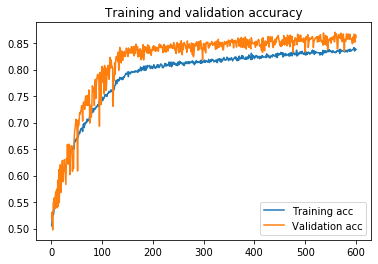

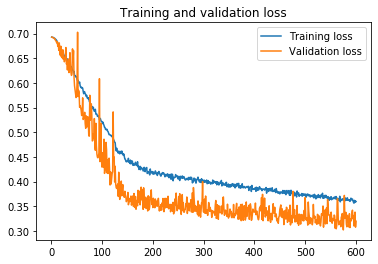

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Acc_600.pdf')
plt.show()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss_600.pdf')
plt.show()


In [18]:
# save training history
hist_df=pd.DataFrame(history.history)
hist_df.to_csv('./results/history_600.csv')

In [21]:
# evaluation
# Evaluation on test dataset
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=len(x_test))
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

3742/3742 [==============================] - 1s 356us/step
Loss on test set:  0.33167049288749695
Accuracy on test set:  0.8530197739601135


In [81]:
# Get predictions
preds = model.predict(x_test, batch_size = len(x_test))
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
# preds = np.argmax(preds, axis=-1)
preds = np.reshape(preds,[len(preds),])
# Original labels
orig_test_labels = y_test

print(orig_test_labels.shape)
print(preds.shape)

(3742,)
(3742,)


<Figure size 432x288 with 0 Axes>

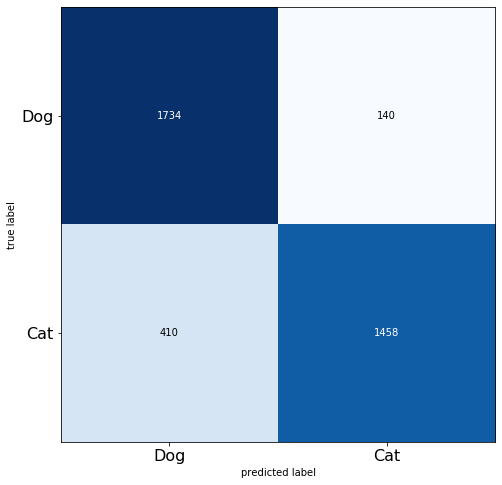

In [101]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Dog', 'Cat'], fontsize=16)
plt.yticks(range(2), ['Dog', 'Cat'], fontsize=16)
plt.show()

In [102]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 score of the model is {:.2f}".format(f1))

Recall of the model is 0.78
Precision of the model is 0.91
F1 score of the model is 0.84


In [14]:
# tensorboard
%tensorboard --logdir ./

UsageError: Line magic function `%tensorboard` not found.
